# Homework 7

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

In [4]:
import tensorflow as tf
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level.

In [2]:
!wget https://raw.githubusercontent.com/yjjjjxx/COMP664-Deep-Learning/main/datasets/100-0.txt

--2023-03-07 16:37:50--  https://raw.githubusercontent.com/yjjjjxx/COMP664-Deep-Learning/main/datasets/100-0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5714775 (5.4M) [text/plain]
Saving to: ‘100-0.txt.1’

100-0.txt.1         100%[===================>]   5.45M  --.-KB/s    in 0.02s   

2023-03-07 16:37:51 (273 MB/s) - ‘100-0.txt.1’ saved [5714775/5714775]



In [3]:
# Read, then decode for py2 compat.
text = open('100-0.txt', 'rb').read()
text = text.decode(encoding='utf-8')
print ('Total number of characters in the corpus is:', len(text))
print('The first 100 characters of the corpus are as follows:\n', text[:100])

Total number of characters in the corpus is: 5668197
The first 100 characters of the corpus are as follows:
 ﻿The Project Gutenberg eBook of The Complete Works of William Shakespeare, by William Shakespeare



In [4]:
# The unique characters in the corpus
vocab = sorted(set(text))
print ('The number of unique characters in the corpus is', len(vocab))
print('A slice of the unique characters set:\n', vocab[:10])

The number of unique characters in the corpus is 111
A slice of the unique characters set:
 ['\t', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&']


In [5]:
# Create a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
# Make a copy of the unique set elements in NumPy array format for later use in the decoding the predictions
idx2char = np.array(vocab)
# Vectorize the text with a for loop
text_as_int = np.array([char2idx[c] for c in text])

In [6]:
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) 
# for i in char_dataset.take(5): 
#   print(i.numpy())
seq_length = 100 # The max. length for single input
# examples_per_epoch = len(text)//(seq_length+1) # double-slash for “floor” division
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) 
# for item in sequences.take(5): 
#   print(repr(''.join(idx2char[item.numpy()])))

In [7]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [8]:
BUFFER_SIZE = 10000 # TF shuffles the data only within buffers

BATCH_SIZE = 64 # Batch size

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>


In [9]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 1024

2. Train a "vanilla" RNN (as described in chapter 8 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.

In [10]:
def build_model_simple(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.SimpleRNN(rnn_units,
                              return_sequences=True,
                              stateful=True,
                              recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [11]:
model_simple = build_model_simple(
    vocab_size = len(vocab), # no. of unique characters
    embedding_dim=embedding_dim, # 256
    rnn_units=rnn_units, # 1024
    batch_size=BATCH_SIZE)  # 64 for the traning

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           28416     
                                                                 
 simple_rnn (SimpleRNN)      (64, None, 1024)          1311744   
                                                                 
 dense (Dense)               (64, None, 111)           113775    
                                                                 
Total params: 1,453,935
Trainable params: 1,453,935
Non-trainable params: 0
_________________________________________________________________


In [12]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# example_batch_loss  = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

model_simple.compile(optimizer='adam', loss=loss)

In [13]:
# Directory where the checkpoints will be saved
checkpoint_dir_simple = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix_simple = os.path.join(checkpoint_dir_simple, "ckpt_{epoch}")

checkpoint_callback_simple=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_simple,
    save_weights_only=True)

In [14]:
EPOCHS = 30
history_simple = model_simple.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback_simple])

Epoch 1/30
876/876 [==============================] - 61s 63ms/step - loss: 2.0394
Epoch 2/30
876/876 [==============================] - 53s 59ms/step - loss: 1.5890
Epoch 3/30
876/876 [==============================] - 53s 59ms/step - loss: 1.4793
Epoch 4/30
876/876 [==============================] - 53s 59ms/step - loss: 1.4292
Epoch 5/30
876/876 [==============================] - 53s 59ms/step - loss: 1.4002
Epoch 6/30
876/876 [==============================] - 53s 59ms/step - loss: 1.3811
Epoch 7/30
876/876 [==============================] - 53s 59ms/step - loss: 1.3683
Epoch 8/30
876/876 [==============================] - 53s 59ms/step - loss: 1.3580
Epoch 9/30
876/876 [==============================] - 53s 59ms/step - loss: 1.3499
Epoch 10/30
876/876 [==============================] - 53s 59ms/step - loss: 1.3424
Epoch 11/30
876/876 [==============================] - 53s 58ms/step - loss: 1.3370
Epoch 12/30
876/876 [==============================] - 52s 58ms/step - loss: 1.3327
E

In [15]:
loss_simple = model_simple.history.history['loss']

Text(0.5, 1.0, 'Simple RNN Training Loss')

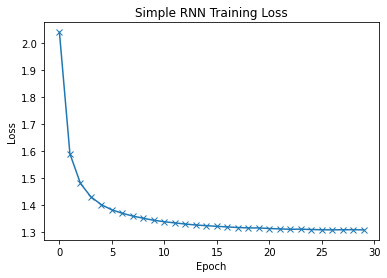

In [17]:
# plot
epochs_range = range(EPOCHS)
plt.plot(epochs_range, loss_simple, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple RNN Training Loss')

In [18]:
tf.train.latest_checkpoint(checkpoint_dir_simple)

'./training_checkpoints/ckpt_30'

In [19]:
model_simple = build_model_simple(vocab_size, embedding_dim, rnn_units, batch_size=1)
model_simple.load_weights(tf.train.latest_checkpoint(checkpoint_dir_simple))
model_simple.build(tf.TensorShape([1, None]))
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            28416     
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, None, 1024)           1311744   
                                                                 
 dense_1 (Dense)             (1, None, 111)            113775    
                                                                 
Total params: 1,453,935
Trainable params: 1,453,935
Non-trainable params: 0
_________________________________________________________________


In [19]:
def generate_text(model, num_generate, temperature, start_string):
  input_eval = [char2idx[s] for s in start_string] # string to numbers (vectorizing)
  input_eval = tf.expand_dims(input_eval, 0) # dimension expansion
  text_generated = [] # Empty string to store our results
  model.reset_states() # Clears the hidden states in the RNN

  for i in range(num_generate): #Run a loop for number of characters to generate
    predictions = model(input_eval) # prediction for single character
    predictions = tf.squeeze(predictions, 0) # remove the batch dimension

    # using a categorical distribution to predict the character returned by the model
    # higher temperature increases the probability of selecting a less likely character
    # lower --> more predictable
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # The predicted character as the next input to the model
    # along with the previous hidden state
    # So the model makes the next prediction based on the previous character
    input_eval = tf.expand_dims([predicted_id], 0) 
    # Also devectorize the number and add to the generated text
    text_generated.append(idx2char[predicted_id]) 

  return (start_string + ''.join(text_generated))

In [21]:
# Simple RNN sample 1
generated_text = generate_text(
                    model_simple, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"ROMEO")
print(generated_text)

ROMEO.
I shall be coctet
As is to
My cram takes of towns” meant to the sky staith speak to hangs the safety and honour in the scapform,
Whose groan. Proclaim from the art vawnts this it more inclasy.
Sit,
Fit threater more kiss,
As to sit a past will live
    Hence, howless for mine
Unlesse shall believiral state to swift; and in that graces,
Of quastly to myself. I am
    age so thus each as it to would lay with violents
Herself these chalror; why may not mind.

THERSITES.
I have rath


In [22]:
# Simple RNN sample 2
generated_text = generate_text(
                    model_simple, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"J")
print(generated_text)

JOYZ#…â
FOLK.
Am I now reason, I will sword that hath unain’d pardon, lost to use hilvia
conflines.
That you would figs,
Star men die, I’ll make then to be rises.
Copsitted.

FALSTAFF.
Say “Sounds, and recolsp'riew’d is your chiands,
    Why, I read.

LEONTES.
How dogether.

SIR TOBY.
It is typalural vestarity._

SIR ANDREW.
O, thou art not so true prino.
I have seen to bridlers prove in such a Saliste.

LEONTES.
I have spirit
    To seeke to vicious issue of his breast his


3. Train a GRU RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?

In [11]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [12]:
model = build_model(
    vocab_size = len(vocab), # no. of unique characters
    embedding_dim=embedding_dim, # 256
    rnn_units=rnn_units, # 1024
    batch_size=BATCH_SIZE)  # 64 for the traning

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           28416     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense (Dense)               (64, None, 111)           113775    
                                                                 
Total params: 4,080,495
Trainable params: 4,080,495
Non-trainable params: 0
_________________________________________________________________


In [13]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# example_batch_loss  = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

model.compile(optimizer='adam', loss=loss)

In [14]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_gru'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [15]:
EPOCHS = 30
history = model.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback])

Epoch 1/30
876/876 [==============================] - 18s 14ms/step - loss: 1.9273
Epoch 2/30
876/876 [==============================] - 10s 10ms/step - loss: 1.3960
Epoch 3/30
876/876 [==============================] - 10s 11ms/step - loss: 1.3054
Epoch 4/30
876/876 [==============================] - 10s 10ms/step - loss: 1.2610
Epoch 5/30
876/876 [==============================] - 10s 10ms/step - loss: 1.2309
Epoch 6/30
876/876 [==============================] - 10s 10ms/step - loss: 1.2095
Epoch 7/30
876/876 [==============================] - 10s 10ms/step - loss: 1.1914
Epoch 8/30
876/876 [==============================] - 10s 10ms/step - loss: 1.1767
Epoch 9/30
876/876 [==============================] - 10s 10ms/step - loss: 1.1648
Epoch 10/30
876/876 [==============================] - 10s 10ms/step - loss: 1.1546
Epoch 11/30
876/876 [==============================] - 10s 10ms/step - loss: 1.1466
Epoch 12/30
876/876 [==============================] - 10s 10ms/step - loss: 1.1396
E

In [16]:
loss = model.history.history['loss']

Text(0.5, 1.0, 'Gru RNN Training Loss')

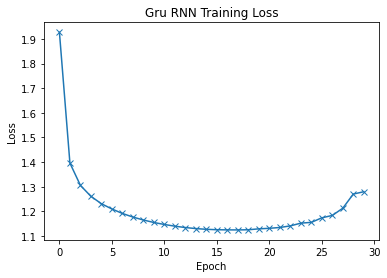

In [17]:
# plot
epochs_range = range(EPOCHS)
plt.plot(epochs_range, loss, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gru RNN Training Loss')

In [18]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints_gru/ckpt_30'

In [19]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            28416     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 111)            113775    
                                                                 
Total params: 4,080,495
Trainable params: 4,080,495
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Gru Sample 1
generated_text = generate_text(
                    model, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"ROMEO")
print(generated_text)

ROMEONA
O, i’ thy love for we, a husband.
That slanders hid when it confus'd too
 To notice that they cold: they were
When he’s e._
She is enclas’d; did, blame, sir, calls,
Beg tryies wooer. Look, where he hath gold and naturally depend.

BAWD.
O, the dust at thy fored-liv’d contrain with, that “thus, nor irhember Juliet of the weat,
Stature with the sweat noble Sterning ripes,
For sound improbined the neighe of teachs
Were well in collor forswo no man but burn to cut of this flames
    


In [21]:
# Gru Sample 2
generated_text = generate_text(
                    model, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"J")
print(generated_text)

JEAN.
It will did you answer him. Which vouchsaffrant’s deaf? I pray.

FALSTAFF.
By thought of Puce not favours sight.
Thricate thought; I shall enjoy the a proter. That act aud
glads,—a hag-gapphient, Priducepolux, hors,
  'SCALUS. Me, lord, I see the silver loud
    Water sweet Bid it.
  VALENTINE. Will I do thuntil end on whter I one; shall all chastish at your cited in it contagus?
Whereto my cour?

BRUTULLALO.
The saught there seen ill by her fortuned design and a boas.

VALER




*   The final training loss of Gru is smaller than simple RNN model. But the difference between them is very small. For me, the text generated by the Gru model is more realistic. When starting with the letter J as a seed character, the Simple RNN model produces unintelligible special symbols in the generated text, whereas the GRU model maintains coherence and produces more plausible output.

4. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?

In [4]:
!wget https://raw.githubusercontent.com/yjjjjxx/COMP664-Deep-Learning/main/datasets/disney.txt

--2023-03-07 22:30:01--  https://raw.githubusercontent.com/yjjjjxx/COMP664-Deep-Learning/main/datasets/disney.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87715 (86K) [text/plain]
Saving to: ‘disney.txt’

disney.txt          100%[===================>]  85.66K  --.-KB/s    in 0.01s   

2023-03-07 22:30:01 (6.08 MB/s) - ‘disney.txt’ saved [87715/87715]



**Read in the Text**

In [1]:
# Read, then decode for py2 compat.
text_disney = open('disney.txt', 'rb').read()
text_disney = text_disney.decode(encoding='utf-8')
print ('Total number of characters in the corpus is:', len(text_disney))
print('The first 200 characters of the corpus are as follows:\n', text_disney[:200])

Total number of characters in the corpus is: 87688
The first 200 characters of the corpus are as follows:
 When somebody loved me
Everything was beautiful
Every hour we spent together
Lives within my heart And when she was sad
I was there to dry her tears
And when she was happy so was I
When she loved me T


**Vectorizing the Text**

In [2]:
# The unique characters in the corpus
vocab1 = sorted(set(text_disney))
print ('The number of unique characters in the corpus is', len(vocab1))
print('A slice of the unique characters set:\n', vocab1[:10])

The number of unique characters in the corpus is 78
A slice of the unique characters set:
 ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.']


In [5]:
# Create a mapping from unique characters to indices
char2idx_1 = {u:i for i, u in enumerate(vocab1)}
# Make a copy of the unique set elements in NumPy array format for later use in the decoding the predictions
idx2char_1 = np.array(vocab1)
# Vectorize the text with a for loop
text_as_int_1 = np.array([char2idx_1[c] for c in text_disney])

**Creating the Dataset**

In [6]:
# Create training examples / targets
char_dataset_disney = tf.data.Dataset.from_tensor_slices(text_as_int_1) 
# for i in char_dataset.take(5): 
#   print(i.numpy())
seq_length = 100 # The max. length for single input
# examples_per_epoch = len(text)//(seq_length+1) # double-slash for “floor” division
sequences_disney = char_dataset_disney.batch(seq_length+1, drop_remainder=True)

In [7]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset_disney = sequences_disney.map(split_input_target)

In [8]:
BUFFER_SIZE = 10000 # TF shuffles the data only within buffers

BATCH_SIZE = 64 # Batch size

dataset_disney = dataset_disney.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset_disney)

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>


**Building the Model**

In [9]:
# Length of the vocabulary in chars
vocab_size = len(vocab1)
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 1024

In [10]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [11]:
model_disney = build_model(
    vocab_size = len(vocab1), # no. of unique characters
    embedding_dim=embedding_dim, # 256
    rnn_units=rnn_units, # 1024
    batch_size=BATCH_SIZE)  # 64 for the traning

model_disney.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           19968     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense (Dense)               (64, None, 78)            79950     
                                                                 
Total params: 4,038,222
Trainable params: 4,038,222
Non-trainable params: 0
_________________________________________________________________


**Compiling and Training**

In [12]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# example_batch_loss  = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

model_disney.compile(optimizer='adam', loss=loss)

In [13]:
# Directory where the checkpoints will be saved
checkpoint_dir_disney = './training_checkpoints/disney'
# Name of the checkpoint files
checkpoint_prefix_disney = os.path.join(checkpoint_dir_disney, "ckpt_{epoch}")

checkpoint_callback_disney=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_disney,
    save_weights_only=True)

In [14]:
EPOCHS = 30
history_disney = model_disney.fit(dataset_disney, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback_disney])

Epoch 1/30
13/13 [==============================] - 10s 132ms/step - loss: 4.1921
Epoch 2/30
13/13 [==============================] - 1s 59ms/step - loss: 3.3241
Epoch 3/30
13/13 [==============================] - 0s 21ms/step - loss: 2.9795
Epoch 4/30
13/13 [==============================] - 0s 18ms/step - loss: 2.7543
Epoch 5/30
13/13 [==============================] - 0s 19ms/step - loss: 2.5650
Epoch 6/30
13/13 [==============================] - 0s 18ms/step - loss: 2.4430
Epoch 7/30
13/13 [==============================] - 0s 18ms/step - loss: 2.3766
Epoch 8/30
13/13 [==============================] - 0s 18ms/step - loss: 2.3288
Epoch 9/30
13/13 [==============================] - 0s 19ms/step - loss: 2.2900
Epoch 10/30
13/13 [==============================] - 0s 17ms/step - loss: 2.2516
Epoch 11/30
13/13 [==============================] - 0s 17ms/step - loss: 2.2114
Epoch 12/30
13/13 [==============================] - 0s 19ms/step - loss: 2.1711
Epoch 13/30
13/13 [================

In [15]:
loss_disney = model_disney.history.history['loss']

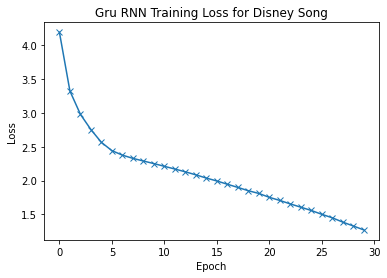

In [25]:
# plot
epochs_range = range(EPOCHS)
plt.plot(epochs_range, loss_disney, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gru RNN Training Loss for Disney Song')
plt.show()

**Generating New Text**

In [17]:
tf.train.latest_checkpoint(checkpoint_dir_disney)

'./training_checkpoints/disney/ckpt_30'

In [18]:
model_disney = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model_disney.load_weights(tf.train.latest_checkpoint(checkpoint_dir_disney))
model_disney.build(tf.TensorShape([1, None]))
model_disney.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            19968     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 78)             79950     
                                                                 
Total params: 4,038,222
Trainable params: 4,038,222
Non-trainable params: 0
_________________________________________________________________


In [21]:
def generate_text(model, num_generate, temperature, start_string):
  input_eval = [char2idx_1[s] for s in start_string] # string to numbers (vectorizing)
  input_eval = tf.expand_dims(input_eval, 0) # dimension expansion
  text_generated = [] # Empty string to store our results
  model.reset_states() # Clears the hidden states in the RNN

  for i in range(num_generate): #Run a loop for number of characters to generate
    predictions = model(input_eval) # prediction for single character
    predictions = tf.squeeze(predictions, 0) # remove the batch dimension

    # using a categorical distribution to predict the character returned by the model
    # higher temperature increases the probability of selecting a less likely character
    # lower --> more predictable
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # The predicted character as the next input to the model
    # along with the previous hidden state
    # So the model makes the next prediction based on the previous character
    input_eval = tf.expand_dims([predicted_id], 0) 
    # Also devectorize the number and add to the generated text
    text_generated.append(idx2char_1[predicted_id]) 

  return (start_string + ''.join(text_generated))

In [23]:
# Disney Sample 1
generated_text = generate_text(
                    model_disney, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"Love")
print(generated_text)

Lovef, Now And you girl ;no I'll bo know hom vime an are
I'm nothe bame A senord there you cunnow
Who is there's dogne the just Leaves It's thes can
When take a little that gett got hoigh
That's decly faralady
I'm hand as sterun
But no rest chem,
heng then world atter in a lot on the bulls of the cluck. Better now I'm to can bellion
Everything? it's agrown that you are I welcome won't star nowereshes for che wish, 'reilot, neverssen to be?
M-I-C-K-E-Y M-O-U-S-E! Mickey
Mous that? I'll sho it the eas




*   The final training loss of Gru RNN for Disney song lyrics is really similar with Shakespeare data. And it is slightly lower than Simple RNN of Shakespeare data.
